<h1>ELG 7172B Assignment 3</h1>
<h3>Submitted by:<br>Harshit Juneja<br>Student ID 300074170</h3>

<h4>Problem 1</h4><br>
Logistic regression with the first and second order gradient descent implemented in Python is presented
here: https://github.com/atcemgil/notes/blob/master/LogisticRegression.ipynb . Analyze the advantages of
using the second order gradient descent.<br><br>
Next, perform logistic regression on one of the following realistic data set for logistic regression
(https://data.princeton.edu/wws509/datasets/#copen) and compare results obtained using different
gradient descent algorithms implemented in NumPy or Tensorflow.
Problem

<h4><u>Solution to Problem 1, part 1</u></h4><br>
<h5>Analysis of Second Order Optimization</h5>

As discussed in [1], the advantages of Newton's method are:
* This method allows us to take advantage of properties of the cost function beyond just the gradient.
* The Hessian matrix describes the local curvature of the function, which allows us to make a more efficient update resulting in faster convergence to the local minima
* It does not use a learning rate. We can calculate the optimal step size using line tracking or approximate the same using Armijo backtracking [2]. Thus, we have one less hyperparameter to tune

However, this method is not without disadvantages, the major challenges being that the Hessian matrix has $n^2$ terms, where n is the number of parameters of the cost function, and further, matrix inversion is a $O(n^{2.81})$ operation. [3]

<h4><u>Solution to Problem 1, part 2</u></h4><br>
For our demonstration of logistic regression using first and second order methods we will be using the Housing Conditions in Copenhagen dataset, which is posted at [4] and is discussed in [5]. As per the [4], the data is in a four-way table format classifying 1681 residents of twelve areas in Copenhagen. We have converted the data into a tab-delimited file and rearranged the columns slightly. The columns, in order are:

* The number of respondents who gave the reponse
* The type of housing (1=tower blocks, 2=apartments, 3=atrium houses and 4=terraced houses)
* Respondent's feeling of influence on apartment management (1=low, 2=medium,3=high),
* Respondent's satisfaction with housing conditions (1=low, 2=medium, 3=high)
* Respondent's degree of contact with neighbors (1=low, 2=high)

We will read this file into python using Numpy, and preprocess the data to perform logistic regression on it.

We will cover the following methods:
* Gradient Descent
* Gradient Descent with momentum
* Gradient Descent with Nesterov accelerated momentun
* Gradient Descent with Newton's method

In [1]:
#importing all the required libraries
import numpy as np
import matplotlib.pyplot as plt
import corner
from sklearn.preprocessing import minmax_scale
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split # we will use this to randomly split our data into two sets
from time import perf_counter
from scipy.stats import multivariate_normal
%matplotlib inline

In [2]:
#reading the file
housing_data = np.genfromtxt('housing_data.tsv', delimiter='\t')
housing_data = housing_data[1:,] #drop the first row (headers)
print("Housing data matrix shape", housing_data.shape)
print("First five rows of housing dataset\nnumber_respondents housing_type",
      "influence satisfaction neighbour_contact\n",  housing_data[0:5])

Housing data matrix shape (72, 5)
First five rows of housing dataset
number_respondents housing_type influence satisfaction neighbour_contact
 [[21.  1.  1.  1.  1.]
 [21.  1.  1.  2.  1.]
 [28.  1.  1.  3.  1.]
 [14.  1.  1.  1.  2.]
 [19.  1.  1.  2.  2.]]


Now, we will un-roll the data by removing the first column, and copying rows as per the number in the first column to get a matrix with 1681 rows and 5 columns. The first column will be all ones for our training the bias weight (this is an "artificial" feature added to the model to make it more robust).

In [3]:
housing_data_unrolled = np.ones((1681,5)) #preallocation
k = 0
for i in range(housing_data.shape[0]):
    num_respondents = int(housing_data[i][0])
    for j in range(num_respondents):
        housing_data_unrolled[k][1:5] = housing_data[i][1:5]
        k += 1
housing_data_unrolled[:,4] -= 1 #change labels for neighbour contact (this will be our predicted variable)
housing_data_unrolled_input = housing_data_unrolled[:,0:4]
housing_data_unrolled_output = housing_data_unrolled[:,4].reshape(-1,1)
#split data into training and validation(test) sets, 75:25
#housing_data_train_input, housing_data_test_input = train_test_split(housing_data_unrolled_input, test_size=0.25, random_state=42)
housing_data_train_input, housing_data_test_input, housing_data_train_output, housing_data_test_output = train_test_split(housing_data_unrolled_input, housing_data_unrolled_output, test_size=0.25, random_state=771, shuffle=True)
#to get training input into 4x1260 matrix
housing_data_train_input = housing_data_train_input.T
#to get test input into 4x1260 matrix
housing_data_test_input = housing_data_test_input.T
print("Training subset matrix size = ",housing_data_train_input.shape)
print("Test subset matrix size = ",housing_data_test_input.shape)
#best random state = 2

Training subset matrix size =  (4, 1260)
Test subset matrix size =  (4, 421)


Our logistic regression model is

\begin{align}
y = f(z) = \frac{1}{1 + e^{-z}}\tag{1}
\end{align}

where, 

\begin{align}
z = b + w_1 * \textrm{housing_type} + w_2 * \textrm{influence} + w_3 * \textrm{satisfaction}\tag{2}
\end{align}
<br>Here, $y$ is our predicted variable, whether a person has low neighbour contact (0) or high neighbour contact and $b$ is the bias term. Combining all the inputs together as matrix x, we can rewrite z as<br>

\begin{align}
z_i = w^Tx_i + b \tag{3}
\end{align}

$w$ is $3{\times}1$ vector, $w = \begin{smallmatrix} [w_1 & w_2 & w_3]^T\end{smallmatrix}$ and $x = \begin{smallmatrix}[\textrm{housing_type}_i & \textrm{influence}_i & \textrm{satisfaction}_i] \end{smallmatrix}$ where $i$ is sample number.<br>

To incorporate the bias term into matrix multiplication, we can rewrite $x_i$ as $\mathbf{x_i} = \begin{smallmatrix}[1 & \textrm{housing_type}_i & \textrm{influence}_i & \textrm{satisfaction}_i] \end{smallmatrix}$ and $w$ as $\mathbf{w} = \begin{smallmatrix} [w_0 & w_1 & w_2 & w_3]^T\end{smallmatrix}$ where $w_0 = b$.<br> 
Further, we can take all our inputs together as a matrix of size $n{\times}m$, where $n$ is the number of features per sample, and $m$ is the number of input samples. We will label this matrix as $\mathbf{X}$. In our chosen problem, $n=4$ (3 features, plus 1 term for bias) and $m=1260$ (size of training subset).

We can now rewrite equation $(3)$, where $\mathbf{z}$ holds a row vector of size $1{\times}m$

\begin{align}
\mathbf{z} = \mathbf{w}^T\mathbf{X} \tag{4}
\end{align}

<b>Maximum Likelihood estimation and cost function</b>

\begin{align}
P(y_i=1|\mathbf{x}_i;\mathbf{w}) = h_\mathbf{w}(\mathbf{x}_i) \tag{5.1}\\
P(y_i=0|\mathbf{x}_i;\mathbf{w}) = 1 - h_\mathbf{w}(\mathbf{x}_i) \tag{5.2}\\
\end{align}
<br>
Here $h_\mathbf{w}(x)$ is the hypothesis function, telling us the probability of $y_i$ = 1, with weights w<br>

Equations $(5)$ can be combined as
\begin{align}
P(y_i|\mathbf{x}_i;\mathbf{w}) = h_\mathbf{w}(\mathbf{x}_i)^{y_i} [1 - h_\mathbf{w}(\mathbf{x}_i)]^{(1-y_i)} \tag{6}\\
\end{align}

The likelihood function is defined as
\begin{align}
L(\mathbf{w}) = \prod_{i=1}^{m} P({y}_i|\mathbf{x}_i;\mathbf{w}) \tag{7}\\
L(\mathbf{w}) = \prod_{i=1}^{m} h_\mathbf{w}(\mathbf{x}_i)^{y_i} [1 - h_\mathbf{w}(\mathbf{x}_i)]^{(1-y_i)} \tag{8} \\
\end{align}
To get the best predictions, we need to maximize the likelihood function. Taking log on both sides, the log likelihood is given as:
\begin{align}
log(L(\mathbf{w})) = \sum_{i=1}^{m} y_i * log(h_\mathbf{w}(\mathbf{x}_i)) + (1-y_i) * log( 1 - h_\mathbf{w}(\mathbf{x}_i)) \tag{9} \\
\end{align}
This is a concave function. To use convex optimization, we define a cost function which is the average of  the negative of log likelihood and minimize it.
\begin{align}
\mathcal{L}(\mathbf{w}) = -\frac{1}{m}[y_i * log(h_\mathbf{w}(\mathbf{x}_i)) + (1-y_i) * log( 1 - h_\mathbf{w}(\mathbf{x}_i))] \tag{10}) \\
\end{align}
<b>First order optimization - Gradient Descent</b><br><br>
The gradients are
\begin{align}
\nabla\mathcal{L} = \frac{1}{m} \sum_{1}^{m}(h_\mathbf{w}(\mathbf{x}_i) - y_i)\mathbf{x}_i \tag{11}\\
\end{align}
Our weight update equation for gradient descent is
\begin{align}
\mathbf{w}_{t+1} = \mathbf{w}_t - \eta \nabla\mathcal{L}(\mathbf{w}) \tag{12}\\
\end{align}
<br>Here $\eta$ is the learning rate, $0<\eta<1$, typically, we choose $\eta$ between $0.01$ and $0.001$ <br><br>

In [4]:
#defining sigmoid function
def sigmoid(z):
    return 1/(1+np.exp(-z))

In [5]:
prng = np.random.RandomState(42) #seeding prng for repeatable results
w = prng.rand(4,1) #random initialization of weights
learning_rate = 0.01
x = housing_data_train_input
y = housing_data_train_output.T
m = housing_data_train_input.shape[1]
epochs = 100000 # upto 1,00,000 iterations
convergence_threshold = 1e-17
error = np.zeros((epochs,2))
#simple gradient descent - no momentum
prev_error = 0
time_start = perf_counter()
for i in range(1,epochs+1):
    z = np.dot(w.T,x)
    predicted_y = sigmoid(z)
    error[i] = np.array([i, np.sum( -y*np.log(predicted_y) - (1-y)*np.log(1-predicted_y) ) / m])
    curr_error = error[i,1]
    if i > epochs/100 and i > 100 and abs(abs(curr_error) - abs(prev_error)) < convergence_threshold:
        print("Convergence threshold reached at epoch", i-1)
        break
    if(i % (epochs/10) == 0):
        print("[epoch\t error] = ", error[i],"elapsed time ", perf_counter()-time_start)
    #calculate gradients
    grad_w = (1/m) * np.sum((predicted_y - y)*x, axis = 1).reshape(-1,1)
    #calculate weight update
    delta_w = learning_rate * grad_w
    #update weights
    w = w - delta_w
    prev_error = curr_error
time_2_converge = perf_counter()-time_start
print("total time = ", time_2_converge)
print("Average time per epoch = ",1000000*time_2_converge/(i-1), "us")
print("The weights are\n", w)

[epoch	 error] =  [1.00000000e+04 6.62326918e-01] elapsed time  0.9687092719999999
[epoch	 error] =  [2.00000000e+04 6.62272656e-01] elapsed time  1.9211592419999999
[epoch	 error] =  [3.00000000e+04 6.62268172e-01] elapsed time  2.8729747139999997
[epoch	 error] =  [4.00000000e+04 6.62267801e-01] elapsed time  3.866280134
[epoch	 error] =  [5.00000000e+04 6.62267771e-01] elapsed time  4.838819265
[epoch	 error] =  [6.00000000e+04 6.62267768e-01] elapsed time  5.8002615209999995
[epoch	 error] =  [7.00000000e+04 6.62267768e-01] elapsed time  6.76300281
[epoch	 error] =  [8.00000000e+04 6.62267768e-01] elapsed time  7.729535681
Convergence threshold reached at epoch 81837
total time =  7.907080504
Average time per epoch =  96.6198724782189 us
The weights are
 [[-0.29591636]
 [ 0.27906364]
 [-0.25329184]
 [ 0.25067246]]


The training took $81,837$ epochs. Now, let us check the accuracy of our model on both training and test data and plot the cost function versus number of epochs. We use logarithmic scale on x-axis due to large number of epochs.

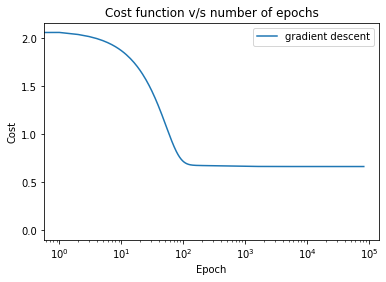

Accuracy summary of training set predictions
 [False  True] 
 [489 771]
Accuracy on training set =  61.19 %
Accuracy summary of test set predictions
 [False  True] 
 [164 257]
Accuracy on test set =  61.05 %


In [6]:
grad_descent_error = error[0:i]
plt.semilogx(grad_descent_error[:,0], grad_descent_error[:,1], label='gradient descent')
plt.title('Cost function v/s number of epochs')
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.legend(loc='upper right')
plt.show()

z = np.dot(w.T,housing_data_train_input)
y2 = sigmoid(z)
for j in range(y2.shape[1]):
    if y2[0,j] > 0.5:
        y2[0,j] = 1
    else:
        y2[0,j] = 0
correct_prediction = y2 == housing_data_train_output.T
unique, counts = np.unique(correct_prediction, return_counts=True)
print("Accuracy summary of training set predictions\n", unique, "\n", counts)
print("Accuracy on training set = ",round(100*counts[1]/housing_data_train_output.shape[0],2),"%")
z = np.dot(w.T,housing_data_test_input)
y2 = sigmoid(z)
for j in range(y2.shape[1]):
    if y2[0,j] > 0.5:
        y2[0,j] = 1
    else:
        y2[0,j] = 0
correct_prediction = y2 == housing_data_test_output.T
unique, counts = np.unique(correct_prediction, return_counts=True)
print("Accuracy summary of test set predictions\n", unique, "\n", counts)
print("Accuracy on test set = ",round(100*counts[1]/housing_data_test_output.shape[0],2),"%")

<b>First order optimization - Gradient Descent with momentum</b>

In this method, we add a momentum term to the update vector. A fraction of the previous epoch's update vector is added to the current epoch's update vector. Our update equations are:

$$\mathbf{v}_t = \gamma * \mathbf{v}_{t-1} + \eta\nabla\mathcal{L}(\mathbf{w}) \tag{13}$$

$$\mathbf{w}_{t+1} = \mathbf{w}_t - v_t \tag{14}$$

This allows for larger updates at the beginning of the optimization process. We have a new update hyperparameter, $0< \gamma \leq 1$. Typically, we begin with $\gamma = 0.9$ and then lower it if needed [6].

In [7]:
prng = np.random.RandomState(42) #seeding prng for repeatable results
w = prng.rand(4,1) #random initialization of weights
p = np.zeros((4,1))
p_prev = np.zeros((4,1))
delta_w = np.zeros((4,1))
learning_rate = 0.01
gamma = 0.9
x = housing_data_train_input
y = housing_data_train_output.T
m = housing_data_train_input.shape[1]
epochs = 100000 # upto 1,00,000 iterations
convergence_threshold = 1e-17
error = np.zeros((epochs,2))
#simple gradient descent - no momentum
prev_error = 0
time_start = perf_counter()
for i in range(1,epochs+1):
    z = np.dot(w.T,x) 
    predicted_y = sigmoid(z)
    error[i] = np.array([i, np.sum( -y*np.log(predicted_y) - (1-y)*np.log(1-predicted_y) ) / m])
    curr_error = error[i,1]
    if i > epochs/100 and i > 100 and abs(abs(curr_error) - abs(prev_error)) < convergence_threshold:
        print("Convergence threshold reached at epoch", i-1)
        break
    if(i % (epochs/10) == 0):
        print("[epoch\t error] = ", error[i],"elapsed time ", perf_counter()-time_start)
    #calculate gradients
    grad_w = (1/m) * np.sum((predicted_y - y)*x, axis = 1).reshape(-1,1)
    #calculate momentum
    p = gamma * p_prev + learning_rate * grad_w
    #update weights
    w = w - p
    p_prev = p
    prev_error = curr_error
time_2_converge = perf_counter()-time_start
print("total time = ", time_2_converge)
print("Average time per epoch = ",1000000*time_2_converge/(i-1), "us")
print("The weights are\n", w)

Convergence threshold reached at epoch 9116
total time =  0.8866047170000009
Average time per epoch =  97.258086551119 us
The weights are
 [[-0.29592534]
 [ 0.27906508]
 [-0.25329051]
 [ 0.25067385]]


We get the same weights as before but in almost half the epochs. It took only $9,116$ epochs to converge which is $11.14 \%$ of simple gradient descent (our baseline).
<br>
We will again check the accuracy of our model on both training and test data. Further, we plot all cost functions v/s epochs to compare. We use logarithmic scale on x-axis due to large number of epochs.

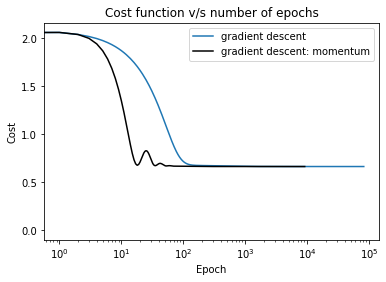

Accuracy summary of training set predictions
 [False  True] 
 [489 771]
Accuracy on training set =  61.19 %
Accuracy summary of test set predictions
 [False  True] 
 [164 257]
Accuracy on test set =  61.05 %


In [8]:
grad_descent_momentum_error = error[0:i]
plt.semilogx(grad_descent_error[:,0], grad_descent_error[:,1], label='gradient descent')
plt.semilogx(grad_descent_momentum_error[:,0], grad_descent_momentum_error[:,1], label='gradient descent: momentum', c = 'black')
plt.title('Cost function v/s number of epochs')
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.legend(loc='upper right')
plt.show()

z = np.dot(w.T,housing_data_train_input)
y2 = sigmoid(z)
for j in range(y2.shape[1]):
    if y2[0,j] > 0.5:
        y2[0,j] = 1
    else:
        y2[0,j] = 0
correct_prediction = y2 == housing_data_train_output.T
unique, counts = np.unique(correct_prediction, return_counts=True)
print("Accuracy summary of training set predictions\n", unique, "\n", counts)
print("Accuracy on training set = ",round(100*counts[1]/housing_data_train_output.shape[0],2),"%")
z = np.dot(w.T,housing_data_test_input)
y2 = sigmoid(z)
for j in range(y2.shape[1]):
    if y2[0,j] > 0.5:
        y2[0,j] = 1
    else:
        y2[0,j] = 0
correct_prediction = y2 == housing_data_test_output.T
unique, counts = np.unique(correct_prediction, return_counts=True)
print("Accuracy summary of test set predictions\n", unique, "\n", counts)
print("Accuracy on test set = ",round(100*counts[1]/housing_data_test_output.shape[0],2),"%")

<b>First order optimization - Gradient Descent with Nesterov accelerated momentum</b>

Nesterov Accelerated Gradient [7] is an improvement over momentum. In this method, we predict the parameters for the next iteration and take a gradient with respect to this prediction. This allows a better update and thus faster convergence. Our update equations are:

$$\mathbf{v}_t = \gamma * \mathbf{v}_{t-1} + \eta\nabla\mathcal{L}(\mathbf{w} - \gamma * \mathbf{v}_{t-1}) \tag{15}$$

$$\mathbf{w}_{t+1} = \mathbf{w}_t - \mathbf{v_t} \tag{16}$$

In [9]:
prng = np.random.RandomState(42) #seeding prng for repeatable results
w = prng.rand(4,1) #random initialization of weights
p = np.zeros((4,1))
p_prev = np.zeros((4,1))
delta_w = np.zeros((4,1))
learning_rate = 0.01
gamma = 0.9
x = housing_data_train_input
y = housing_data_train_output.T
m = housing_data_train_input.shape[1]
epochs = 100000 # upto 1,00,000 iterations
convergence_threshold = 1e-17
error = np.zeros((epochs,2))
#simple gradient descent - no momentum
prev_error = 0
time_start = perf_counter()
for i in range(1,epochs+1):
    w = w - gamma * p_prev #Nesterov parameter prediction
    z = np.dot(w.T,x)
    predicted_y = sigmoid(z)
    error[i] = np.array([i, np.sum( -y*np.log(predicted_y) - (1-y)*np.log(1-predicted_y) ) / m])
    curr_error = error[i,1]
    if i > epochs/100 and i > 100 and abs(abs(curr_error) - abs(prev_error)) < convergence_threshold:
        print("Convergence threshold reached at epoch", i-1)
        break
    if(i % (epochs/10) == 0):
        print("[epoch\t error] = ", error[i],"elapsed time ", perf_counter()-time_start)
    #calculate gradients
    grad_w = (1/m) * np.sum((predicted_y - y)*x, axis = 1).reshape(-1,1)
    #calculate momentum
    p = gamma * p_prev + learning_rate * grad_w
    #update weights
    w = w - p
    p_prev = p
    prev_error = curr_error
time_2_converge = perf_counter()-time_start
print("total time = ", time_2_converge)
print("Average time per epoch = ",1000000*time_2_converge/(i-1), "us")
print("The weights are\n", w)

Convergence threshold reached at epoch 4875
total time =  0.48040998499999965
Average time per epoch =  98.54563794871787 us
The weights are
 [[-0.29592626]
 [ 0.27906523]
 [-0.25329037]
 [ 0.25067399]]


Nesterov accelerated gradient is about twice as fast as momentum. It took $4,875$ epochs which is $5.96 \%$ of of the baseline.
<br>
We will again check the accuracy of our model on both training and test data. Further, we plot all cost functions v/s epochs to compare. We use logarithmic scale on x-axis due to large number of epochs.

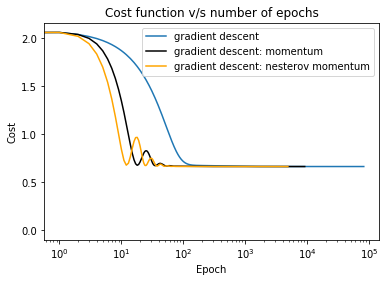

Accuracy summary of training set predictions
 [False  True] 
 [489 771]
Accuracy on training set =  61.19 %
Accuracy summary of test set predictions
 [False  True] 
 [164 257]
Accuracy on test set =  61.05 %


In [10]:
nesterov_momentum_error = error[0:i]
plt.semilogx(grad_descent_error[:,0], grad_descent_error[:,1], label='gradient descent')
plt.semilogx(grad_descent_momentum_error[:,0], grad_descent_momentum_error[:,1], label='gradient descent: momentum', c = 'black')
plt.semilogx(nesterov_momentum_error[:,0], nesterov_momentum_error[:,1], label='gradient descent: nesterov momentum', c = 'orange')
plt.title('Cost function v/s number of epochs')
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.legend(loc='upper right')
plt.show()

z = np.dot(w.T,housing_data_train_input)
y2 = sigmoid(z)
for j in range(y2.shape[1]):
    if y2[0,j] > 0.5:
        y2[0,j] = 1
    else:
        y2[0,j] = 0
correct_prediction = y2 == housing_data_train_output.T
unique, counts = np.unique(correct_prediction, return_counts=True)
print("Accuracy summary of training set predictions\n", unique, "\n", counts)
print("Accuracy on training set = ",round(100*counts[1]/housing_data_train_output.shape[0],2),"%")
z = np.dot(w.T,housing_data_test_input)
y2 = sigmoid(z)
for j in range(y2.shape[1]):
    if y2[0,j] > 0.5:
        y2[0,j] = 1
    else:
        y2[0,j] = 0
correct_prediction = y2 == housing_data_test_output.T
unique, counts = np.unique(correct_prediction, return_counts=True)
print("Accuracy summary of test set predictions\n", unique, "\n", counts)
print("Accuracy on test set = ",round(100*counts[1]/housing_data_test_output.shape[0],2),"%")

<b>Second order optimization - Gradient Descent with Newton-Raphson method</b><br><br>
Newton-Raphson uses the derivative of the gradient, that is, a second order derivative of the error function to rapidly converge to the minima.

The update equation in Newton-Raphson method is

$$\mathbf{w}_{t+1} = \mathbf{w}_{t} - \alpha [\nabla^2\mathcal{L}(\mathbf{w})]^{-1}\nabla \mathcal{L}(\mathbf{w})) \tag{17}$$

<br>$\alpha$ is an adaptive step size, that is, we reduce the value of alpha if the error increases rather than decrease to ensure that our model converges.

$\nabla^2\mathcal{L}(\mathbf{w})$ is the Hessian matrix, $H$.
It consists of mixed second order partial derivatives of the loss function:

$$H = 
\begin{bmatrix}
\frac{\partial^2 \mathcal{L}}{\partial w_1^2} & \frac{\partial^2 \mathcal{L}}{\partial w_1 \partial w_2} & \dots &\frac{\partial^2 \mathcal{L}}{\partial w_1 \partial w_n} \\
\frac{\partial^2 \mathcal{L}}{\partial w_2 \partial w_1} & \frac{\partial^2 \mathcal{L}}{\partial w_2^2} & \dots & \frac{\partial^2 \mathcal{L}}{\partial w_2 \partial w_n} \\
\vdots & \vdots  & \ddots & \vdots \\
\frac{\partial^2 \mathcal{L}}{\partial w_n \partial w_1} & \frac{\partial^2 \mathcal{L}}{\partial w_n \partial w_2} & \dots & \frac{\partial^2 \mathcal{L}}{\partial w_n^2} \tag{18}
\end{bmatrix}
$$

In [11]:
prng = np.random.RandomState(42) #seeding prng for repeatable results
w = prng.rand(4,1) #random initialization of weights
p = np.zeros((4,1))
delta_w = np.zeros((4,1))
H = np.zeros((4,4))
step_size = 0.02
x = housing_data_train_input
y = housing_data_train_output.T
m = housing_data_train_input.shape[1]
epochs = 100000 # upto 1,00,000 iterations
convergence_threshold = 1e-17
error = np.zeros((epochs,2))
#simple gradient descent - no momentum
prev_error = 0
time_start = perf_counter()
for i in range(1,epochs+1):
    z = np.dot(w.T,x) 
    predicted_y = sigmoid(z)
    error[i] = np.array([i, np.sum( -y*np.log(predicted_y) - (1-y)*np.log(1-predicted_y) ) / m])
    curr_error = error[i,1]
    if i>0 and curr_error > prev_error:
        step_size = 0.9*step_size
    if i > epochs/100 and i > 100 and abs(abs(curr_error) - abs(prev_error)) < convergence_threshold:
        print("Convergence threshold reached at epoch", i-1)
        break
    if(i % (epochs/10) == 0):
        print("[epoch\t error] = ", error[i],"elapsed time ", perf_counter()-time_start)
    #calculate gradients
    grad_w = (1/m) * np.sum((predicted_y - y)*x, axis = 1).reshape(-1,1)
    #calculate hessian
    k = predicted_y*(1 - predicted_y)
    for i in range(H.shape[0]):
        for j in range(H.shape[1]):
            H[i,j] = (1/m) * np.sum(k * x[i].reshape(1,-1) * x[j].reshape(1,-1))
    H_inv = np.linalg.inv(H)
    #calculate weight update
    delta_w = np.dot(H_inv, grad_w)
    #update weights
    w = w - step_size*delta_w
    prev_error = curr_error
time_2_converge = perf_counter()-time_start
print("total time = ", time_2_converge)
print("Average time per epoch = ",1000000*time_2_converge/(i-1), "us")
print("The weights are\n", w)

Convergence threshold reached at epoch 1000
total time =  0.30795596699999983
Average time per epoch =  307.9559669999998 us
The weights are
 [[-0.29592853]
 [ 0.2790656 ]
 [-0.25329003]
 [ 0.25067434]]


With Newton-Raphson method, our logistic regression converged in $1,000$ epochs which is $1.22 \%$ of of the baseline!
<br>
We will again check the accuracy of our model on both training and test data. Further, we plot all cost functions v/s epochs to compare. We use logarithmic scale on x-axis due to large number of epochs.

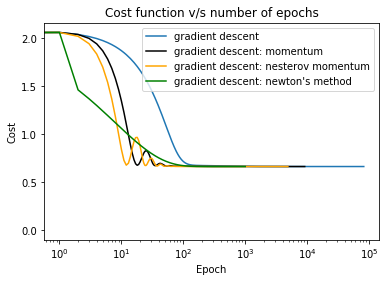

Accuracy summary of training set predictions
 [False  True] 
 [489 771]
Accuracy on training set =  61.19 %
Accuracy summary of test set predictions
 [False  True] 
 [164 257]
Accuracy on test set =  61.05 %


In [12]:
newton_method_error = error[0:i]
plt.semilogx(grad_descent_error[:,0], grad_descent_error[:,1], label='gradient descent')
plt.semilogx(grad_descent_momentum_error[:,0], grad_descent_momentum_error[:,1], label='gradient descent: momentum', c = 'black')
plt.semilogx(nesterov_momentum_error[:,0], nesterov_momentum_error[:,1], label='gradient descent: nesterov momentum', c = 'orange')
plt.semilogx(newton_method_error[:,0], newton_method_error[:,1], label='gradient descent: newton\'s method', c = 'green')
plt.title('Cost function v/s number of epochs')
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.legend(loc='upper right')
plt.show()

z = np.dot(w.T,housing_data_train_input)
y2 = sigmoid(z)
for j in range(y2.shape[1]):
    if y2[0,j] > 0.5:
        y2[0,j] = 1
    else:
        y2[0,j] = 0
correct_prediction = y2 == housing_data_train_output.T
unique, counts = np.unique(correct_prediction, return_counts=True)
print("Accuracy summary of training set predictions\n", unique, "\n", counts)
print("Accuracy on training set = ",round(100*counts[1]/housing_data_train_output.shape[0],2),"%")
z = np.dot(w.T,housing_data_test_input)
y2 = sigmoid(z)
for j in range(y2.shape[1]):
    if y2[0,j] > 0.5:
        y2[0,j] = 1
    else:
        y2[0,j] = 0
correct_prediction = y2 == housing_data_test_output.T
unique, counts = np.unique(correct_prediction, return_counts=True)
print("Accuracy summary of test set predictions\n", unique, "\n", counts)
print("Accuracy on test set = ",round(100*counts[1]/housing_data_test_output.shape[0],2),"%")

<h3>Summary of Gradient Methods</h3>

<table style="width:99%">
  <tr>
    <th>Metric</th>
    <th>Gradient Descent</th>
    <th>Gradient Descent: First-Order Momentum</th>
    <th>Gradient Descent: Nesterov Momentum</th>
    <th>Gradient Descent: Newton-Raphson Method</th>
  </tr>
  <tr>
    <td>Epochs to Convergence</td>
    <td>$81,837$</td>
    <td>$9,116$</td>
    <td>$4,875$</td>
    <td>$1,000$</td>
  </tr>
  <tr>
    <td>Epochs to Convergence (percent of baseline)</td>
    <td>$100 \%$ (baseline)</td>
    <td>$11.14 \%$</td>
    <td>$5.96 \%$</td>
    <td>$1,000$</td>
  </tr>
  <tr>
    <td>Time to convergence (seconds)</td>
    <td>$7.44$</td>
    <td>$0.85$</td>
    <td>$0.46$</td>
    <td>$0.30$</td>
  </tr>
  <tr>
    <td>Average time per epoch ($\mu s$)</td>
    <td>$91$</td>
    <td>$93$</td>
    <td>$94$</td>
    <td>$298$</td>
  </tr>
    <td>Hyperparameters</td>
    <td>$\eta = 0.01$</td>
    <td>$\eta = 0.01, \gamma = 0.9$</td>
    <td>$\eta = 0.01, \gamma = 0.9$</td>
    <td>Step size $ = 0.02$</td>
  </tr>
  <tr>
    <td>Training accuracy</td>
    <td>$61.19 \%$</td>
    <td>$61.19 \%$</td>
    <td>$61.19 \%$</td>
    <td>$61.19 \%$</td>
  </tr>
  <tr>
    <td>Test accuracy</td>
    <td>$61.05 \%$</td>
    <td>$61.05 \%$</td>
    <td>$61.05 \%$</td>
    <td>$61.05 \%$</td>
  </tr>
  </tr>
</table>

<u>Please Note:</u> The execution time depends on a multitude of factors including but not limited to the specification, configuration, and the background workload on a computer. Therefore, the time figures in the table above may not match between any two executions of this notebook.

---

<h4>Problem 3</h4><br>

The goal of this example is to demonstrate the application of the EM algorithm in the context of the Gaussian mixture modeling. The data are generated according to three Gaussians in the two-dimensional space, with parameters,<br>

$\mu_1 = \begin{bmatrix} 10 & 3\end{bmatrix}^T$, $\mu_2 = \begin{bmatrix} 1 & 1\end{bmatrix}^T$, $\mu_3 = \begin{bmatrix} 5 & 4\end{bmatrix}^T$
<br><br>and<br><br>
$\Sigma_1 = \begin{bmatrix} 1 & 0 \\ 0 & 1\end{bmatrix}$,
$\Sigma_2 = \begin{bmatrix} 1.5 & 0 \\ 0 & 1.5\end{bmatrix}$,
$\Sigma_3 = \begin{bmatrix} 2 & 0 \\ 0 & 2\end{bmatrix}$

<br>a) Derive EM algorithm.
<br>b) Implement it in Python. The number of the generated points is 300 with 100 points per mixture.
Your initial values for EM algorithm are:<br><br>
$\mu_1^{(0)} = \begin{bmatrix} 3 & 5\end{bmatrix}^T$, $\mu_2^{(0)} = \begin{bmatrix} 2 & 0.4\end{bmatrix}^T$, $\mu_3^{(0)} = \begin{bmatrix} 4 & 3\end{bmatrix}^T$,
<br><br>
$\Sigma_1 = \Sigma_2 = \Sigma_3 = \begin{bmatrix} 1 & 0 \\ 0 & 1\end{bmatrix}$
<br><br>c) Analyze dependence on the good initialization for the EM algorithm. Run the algorithm with the
same initial values for the covariance but the following initial values for the mean:<br><br>
$\mu_1^{(0)} = \begin{bmatrix} 10 & 13\end{bmatrix}^T$, $\mu_2^{(0)} = \begin{bmatrix} 11 & 12\end{bmatrix}^T$, $\mu_3^{(0)} = \begin{bmatrix} 13 & 11\end{bmatrix}^T$

<h4><u>Solution to Problem 3, part a)</u></h4><br>

A Gaussian Mixture is a function comprised Gaussians, where each data point $\mathbf{x}_n$ is generated by a different underlying Gaussian distribution specified by a hidden variable $z_n \in {1,\dots,K}$ where $K$ is the number of clusters. Since we do not know $z_n$, we used Expectation Maximization (EM) algorithm to estimate the hidden variables, and effectively partition our data into clusters. For each Gaussian, there are parameters:
* Mean, $\mu$
* Covariance Matrix, $\Sigma$
* Mixing probability, $\pi$

For mixing probabilities,
$$\sum_{k=1}^K \pi_k = 1 \tag{19}$$

To find the optimal values for the above parameters, we need to maximize the log-likelihood of the observed data.

In general, a Gaussian distribition is given by:
$$\mathcal{N}(\mathbf{x}|\mu,\Sigma) = \frac{1}{(2\pi)^{D/2}|\Sigma|^{1/2}}e^{-\frac{1}{2}(\mathbf{x} - \mu)^T \Sigma^{-1}(\mathbf{x} - \mu)} \tag{20}$$

Here $\mathbf{x}$ are our data points, $D$ is the number of dimensions for each point, and $\mu$ and $\Sigma$ are, respectively, mean and covariance. To find the Maximum Likelihood Estimates (MLE), we can differentiate equation $(20)$ with respect to $\mu$ and $\Sigma$ and set the derivative to zero. But first, some notation.<br>
Probability that data point $\mathbf{x}_n$ came from Gaussian $k$<br><br>
$$p(z_{nk} = 1| \mathbf{x}_n), z_{nk} \in \{0,1\} \tag{21}$$
<br>If $\mathbf{x} \in z, p(z) = 1$ otherwise $p(z) = 0$. Similarly,<br>
$$\pi_k = p(z_k = 1) \tag{22}$$
Now, let $\mathbf{z} = \{z_1,\dots,z_K\}$ be the set of all hidden variables.
$$p(\mathbf{z}) = p(z_1 = 1)^{z_1}p(z_2 = 1)^{z_2}\dots p(z_K = 1)^{z_K} = \prod_{k=1}^{K} \pi_k^{z_k} \tag{23}$$
<br> Probability of observing the data $\mathbf{x}_n$ if we know that it comes from Gaussian k is given by Gaussian pmf
$$p(\mathbf{x}_n|\mathbf{z}) = \prod_{k=1}^{K}\mathcal{N}(\mathbf{x}_n|\mu_k,\Sigma_k)^{z_k} \tag{24}$$
<br>$$p(\mathbf{x}_n) = \sum_{k=1}^K p(\mathbf{x}_n|\mathbf{z})p(\mathbf{z}) =  \sum_{k=1}^K \pi_k\mathcal{N}(\mathbf{x}_n|\mu_k,\Sigma_k) \tag{25}$$
<br>To determine optimal values for our parameters, we need to find the maximum likelihood of the model. The likelihood is the joint probability of all observations $\mathbf{x}_n$, defined as:
$$p(\mathbf{X}) = \prod_{k=1}^{K} p(\mathbf{x}_n) = \prod_{k=1}^{K}\sum_{k=1}^K \pi_k\mathcal{N}(\mathbf{x}_n|\mu_k,\Sigma_k) \tag{26} $$
<br>Taking log on both sides, 
$$ \log p(\mathbf{X}) = \sum_{k=1}^{K}log\sum_{k=1}^K \pi_k\mathcal{N}(\mathbf{x}_n|\mu_k,\Sigma_k) \tag{27} $$

<br>This is our function to maximize. However, since we cannot push log inside the sum, this is hard to compute. Therfore, we use EM algorithm.<br>From Bayes theorem, we can write<br>
$$p(\mathbf{z}_k = 1|\mathbf{x}_n) = \frac{p(\mathbf{x}_n|\mathbf{z}_k = 1)p(\mathbf{z}_k =1)}{p(\mathbf{x}_n, \mathbf{z}_k=1)}  = \frac{p(\mathbf{x}_n|\mathbf{z}_k = 1)p(\mathbf{z}_k =1)}{\sum_{j=1}^K p(\mathbf{x}_n|\mathbf{z_j}=1)p(\mathbf{z_j}=1)}\tag{28}$$
<br>Using equations $(22)$,$(24)$ and $(25)$, we can rewrite $(28)$ as <br>
$$p(\mathbf{z}_k = 1 |\mathbf{x}_n) = \frac{\pi_k\mathcal{N}(\mathbf{x}_n|\mu_k,\Sigma_k)}{\sum_{j=1}^K \pi_j\mathcal{N}(\mathbf{x}_n|\mu_j,\Sigma_j)} =\gamma(z_{nk}) \tag{29}$$
<br>
The parameters of mode are $\theta = \{\pi,\mu,\Sigma\}$

<h6>Expectation Step</h6>

Evaluate $p(\mathbf{Z}|\mathbf{X},\theta)$. We will calculate<br>
$$p(\mathbf{z}_{nk}|\mathbf{X},\theta) = \mathbb{E}[z_{nk}] = \sum_{j=1}^K z_{nj} \gamma(z_{nj}) = \gamma(z_{nk}) \tag{30}$$

<h6>Maximization Step</h6>

Find the updated parameters $\theta^*$<br>
$$\theta^* = argmax_\theta \mathcal{Q}(\theta^*,\theta) \tag{31}$$
<br>Here,<br> 
$$\mathcal{Q}(\theta^*,\theta) = \mathbb{E}[\log p(\mathbf{X},\mathbf{Z}|\theta^*)] = \sum_{\mathbf{Z}} p(\mathbf{Z}|\mathbf{X},\theta)\log p(\mathbf{X},\mathbf{Z}|\theta^*) \tag{32}$$

We already calculated $p(\mathbf{Z}|\mathbf{X},\theta)$. $p(\mathbf{X},\mathbf{Z}|\theta^*)$ is the complete likelihood of the model, given by<br>
$$ p(\mathbf{X},\mathbf{Z}|\theta^*) = \prod_{n=1}^N\prod_{k=1}^K \pi^{z_{nk}}\mathcal{N}(\mathbf{x}_n|\mu_k,\Sigma_k)^{z_{nk}} \tag{33}$$
<br>Taking log on both sides,<br>
$$\log p(\mathbf{X},\mathbf{Z}|\theta^*) = \sum_{n=1}^N\sum_{k=1}^K z_{nk}[\log \pi_k + \log\mathcal{N}(\mathbf{x}_n|\mu_k,\Sigma_k)] \tag{34}$$
<br>Using equations $(30)$ and $(34)$ in $(32)$, and applying a Lagrange multiplier for mixing coefficients $pi$, we get<br>
$$\mathcal{Q}(\theta^*,\theta) = \sum_{n=1}^N\sum_{k=1}^K \gamma(z_{nk})[\log \pi_k + \log\mathcal{N}(\mathbf{x}_n|\mu_k,\Sigma_k)] - \lambda \left( \sum_{k=1}^K\pi_k - 1\right) \tag{35}$$
<br>Now, to find parameters using maximum likelihood, we differentiate $\mathcal{Q}$ wrt $\pi$ and equate it to zero.
$$\frac {\partial\mathcal{Q}(\theta^*,\theta)}{\partial \pi_k} = \sum_{n=1}^N \frac{\gamma(z_{nk})}{\pi_k} - \lambda = 0 \tag{36}$$
<br>Rearranging terms and summing over both sides,
$$\sum_{k=1}^K\sum_{n=1}^N \gamma(z_{nk}) = \sum_{k=1}^K\pi_k\lambda \tag{37}$$
<br> From equation $(19)$, we know that summing probabilities over $\pi_k$ will give us one. Further, sum of probabilities $\gamma$ over k is also one. Therefore, $\lambda = N$, Solving for $\pi$
$$\pi_k = \frac{\sum_{n=1}^N \gamma(z_{nk})}{N} \tag{38}$$
<br>Similarly, $\mu$ and $\Sigma$ can be computed taking log of equation $(20)$ and equating it to zero.<br>
$$ \mu_k^* = \frac{\sum_{n=1}^N \gamma(z_{nk})\mathbf{x}_n}{\sum_{n=1}^N \gamma(z_{nk})} \tag{39}$$
$$ \Sigma_k^* = \frac{\sum_{n=1}^N \gamma(z_{nk})(\mathbf{x}_n - \mu_k)(\mathbf{x}_n - \mu_k)^T}{\sum_{n=1}^N \gamma(z_{nk})} \tag{40}$$

Now, we can use these values to determine $\gamma$ in the next EM iteration, and repeat until we converge on a likelihod value[8].

<h4><u>Solution to Problem 3, part b)</u></h4><br>

In [13]:
#initialize everything
prng = np.random.RandomState(42) #seeding prng for repeatable results
num_clusters = 3 #given
mu1 = np.array([10, 3])
mu2 = np.array([1, 1])
mu3 = np.array([5, 4])
cov1 = np.array([[1, 0],
                [0, 1]])
cov2 = np.array([[1.5, 0],
                [0, 1.5]])
cov3 = np.array([[2, 0],
                [0, 2]])
#sample from the given distributions, 100 samples each
gaussian1 = prng.multivariate_normal(mu1, cov1, 100)
gaussian2 = prng.multivariate_normal(mu2, cov2, 100)
gaussian3 = prng.multivariate_normal(mu3, cov3, 100)
gaussian_mixture = np.concatenate((gaussian1, gaussian2, gaussian3))
#prng.shuffle(gaussian_mixture)
#combining all 3 gaussians into one

Now, we plot the three gaussian distributions, coded by color.

Text(0.5, 1.0, 'Gaussian Mixture')

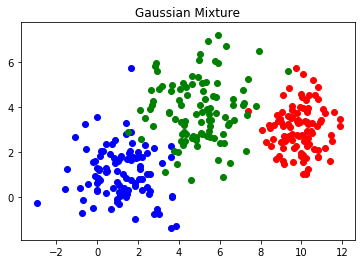

In [14]:
plt.scatter(gaussian1[:,0],gaussian1[:,1], c = 'red')
plt.scatter(gaussian2[:,0],gaussian2[:,1], c = 'blue')
plt.scatter(gaussian3[:,0],gaussian3[:,1], c = 'green')
plt.title('Gaussian Mixture')

In [15]:
#Initial values to start with, as specified in the problem
mu1_initial = np.array([3, 5])
mu2_initial = np.array([2, 0.4])
mu3_initial = np.array([4, 3])
mu_initial = np.stack((mu1_initial, mu2_initial, mu3_initial),axis=0)
cov1_initial = np.array([[1, 0],
                          [0, 1]])
cov2_initial = np.array([[1, 0],
                          [0, 1]])
cov3_initial = np.array([[1, 0],
                          [0, 1]])
cov_initial = np.stack((cov1_initial, cov2_initial, cov3_initial))
pi = np.repeat(1/num_clusters, 3)

We define functions for expectation step, maximization step, and then combine them into a single function to discern the GMM.

In [16]:
#The functions and code below are adapted from [8] and [9]
def expectation(X, n_clusters, pie, mean, var):
    gamma_nk = np.zeros((X.shape[0], n_clusters))
    for cluster in range(n_clusters):
        #using equation (29)
        gamma_nk[:,cluster] = pie[cluster] * multivariate_normal.pdf(X, mean=mean[cluster], cov=var[cluster])
    likelihood = np.sum(np.log(np.sum(gamma_nk,axis=1)))
    gamma_nk /= np.sum(gamma_nk,axis=1).reshape(-1,1)
    return gamma_nk, likelihood

In [17]:
def maximization(X, n_clusters, gamma_nk):
    N = float(X.shape[0])
    cov_k = np.zeros((n_clusters, X.shape[1], X.shape[1]))
    mu_k = np.zeros((n_clusters, X.shape[1]))
    N_k = np.sum(gamma_nk, axis=0)
    pi_k = N_k / N
    for cluster in range(n_clusters):
        mu_k[cluster] = np.dot(gamma_nk[:,cluster].reshape(1,-1), X) / N_k[cluster]
        for i in range(X.shape[0]):
            temp = (X[i]-mu_k[cluster]).reshape(-1,1)
            cov_k[cluster] += gamma_nk[i, cluster] * np.dot(temp, temp.T)
        cov_k[cluster] /= N_k[cluster]
    return pi_k, mu_k, cov_k

In [18]:
def learn_gmm(mixture, n_clusters, pi_init, mu_init, cov_init, epochs):
    likelihoods = np.zeros((epochs, 2))
    pi_pred = pi_init
    mu_pred = mu_init
    cov_pred = cov_init
    time_start = perf_counter()
    for epoch in range(0, epochs):
        gamma, likelihoods[epoch, 1] = expectation(mixture, n_clusters, pi_pred, mu_pred, cov_pred)
        pi_pred, mu_pred, cov_pred, = maximization(mixture, n_clusters, gamma)
        likelihoods[epoch, 0] = epoch
        if(epoch) % (epochs/10) == 0:
            print("[epoch\t likelihood] = ", likelihoods[epoch], "elapsed time ", perf_counter()-time_start)
    return pi_pred, mu_pred, cov_pred, likelihoods, gamma

In [19]:
pi_predicted, mu_predicted, cov_predicted, likelihood_b, gamma = learn_gmm(gaussian_mixture, 3, pi, mu_initial, cov_initial, 50)
print("\nPredicted pi\n", pi_predicted, "\nPredicted means\n", mu_predicted, "\nPredicted variances\n", cov_predicted)

[epoch	 likelihood] =  [    0.         -3070.82338547] elapsed time  0.010134726999998733
[epoch	 likelihood] =  [    5.         -1286.03995708] elapsed time  0.04816481199999956
[epoch	 likelihood] =  [   10.         -1284.76439323] elapsed time  0.07739078899999896
[epoch	 likelihood] =  [   15.         -1280.94073775] elapsed time  0.10656391499999884
[epoch	 likelihood] =  [   20.         -1265.72504439] elapsed time  0.13565479599999897
[epoch	 likelihood] =  [   25.         -1242.66070715] elapsed time  0.1642781959999997
[epoch	 likelihood] =  [   30.         -1242.15491302] elapsed time  0.19271275300000035
[epoch	 likelihood] =  [   35.         -1242.15334202] elapsed time  0.22511413700000027
[epoch	 likelihood] =  [   40.         -1242.15324699] elapsed time  0.2576505949999994
[epoch	 likelihood] =  [   45.        -1242.1532395] elapsed time  0.2913488879999999

Predicted pi
 [0.33902709 0.33041576 0.33055715] 
Predicted means
 [[4.90655839 3.8084069 ]
 [1.17141782 1.016629

Our Gaussian Mixture Model converged in $< 25$ epochs, and our inferred attributes are close to the ones which the distribution was actually generated from. The error would go down as we collect more samples. Let's plot the log-likelihood and our clusters.

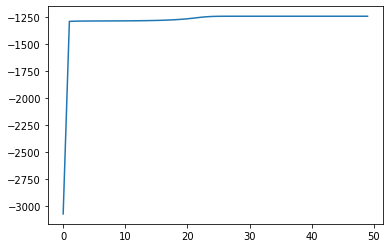

In [20]:
plt.plot(likelihood_b[:,0],likelihood_b[:,1])

In [21]:
gamma = minmax_scale(gamma, feature_range=(0, 1), axis=0, copy=True)

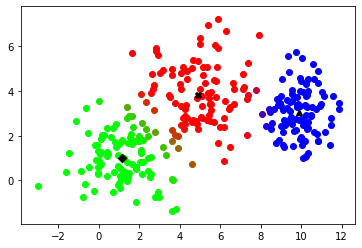

In [22]:
for i in range(gaussian_mixture.shape[0]):
    plt.scatter(gaussian_mixture[i,0], gaussian_mixture[i,1], c=gamma[i].reshape(1,-1))
plt.scatter(mu_predicted[0,0], mu_predicted[0,1], marker='X', c='black')
plt.scatter(mu_predicted[1,0], mu_predicted[1,1], marker='D', c='black')
plt.scatter(mu_predicted[2,0], mu_predicted[2,1], marker='^', c='black')

Observing carefully, we can see the soft color boundaries between the clusters.
<h4><u>Solution to Problem 3, part c)</u></h4><br>

Now, we will use a different initialization far from actual mean and study its impact.

In [23]:
#New initial values for part c
mu1_initial = np.array([10, 13])
mu2_initial = np.array([11, 12])
mu3_initial = np.array([13, 11])
mu_initial = np.stack((mu1_initial, mu2_initial, mu3_initial),axis=0)
pi = np.repeat(1/num_clusters, 3)
pi_predicted, mu_predicted, cov_predicted, likelihood_c, gamma = learn_gmm(gaussian_mixture, 3, pi, mu_initial, cov_initial, 50)
print("\nPredicted pi\n", pi_predicted, "\nPredicted means\n", mu_predicted, "\nPredicted variances\n", cov_predicted)

[epoch	 likelihood] =  [     0.         -20931.16459524] elapsed time  0.00933519699999863
[epoch	 likelihood] =  [    5.         -1265.57456493] elapsed time  0.042722880999999546
[epoch	 likelihood] =  [   10.         -1265.14352339] elapsed time  0.07347868999999996
[epoch	 likelihood] =  [   15.         -1264.93929046] elapsed time  0.10291442999999845
[epoch	 likelihood] =  [   20.         -1264.78516797] elapsed time  0.13239684399999874
[epoch	 likelihood] =  [   25.         -1264.67444508] elapsed time  0.1622816339999993
[epoch	 likelihood] =  [   30.         -1264.60136944] elapsed time  0.19219983599999857
[epoch	 likelihood] =  [   35.         -1264.54770602] elapsed time  0.22549360000000007
[epoch	 likelihood] =  [   40.         -1264.49204534] elapsed time  0.25793619699999937
[epoch	 likelihood] =  [   45.         -1264.40586041] elapsed time  0.28869364100000006

Predicted pi
 [0.13245021 0.54105555 0.32649424] 
Predicted means
 [[3.29622611 4.41301108]
 [3.05537525 1.

We can clearly see the impact of poor initialization on the inferred means and variances. Let us plot the log-likelihood and how it compares with part b).

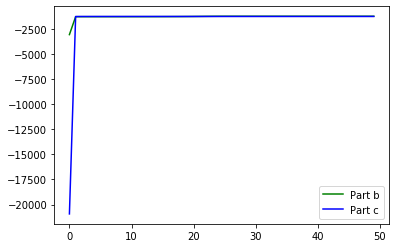

In [24]:
plt.plot(likelihood_b[:,0],likelihood_b[:,1], label='Part b', color='green')
plt.plot(likelihood_c[:,0],likelihood_c[:,1], label='Part c', color='blue')
plt.legend(loc='lower right')

We can see that part c) (blue) starts with a much lower log-likelihood and falls slightly short of part b) at convergence. To highlight this, we plot a graph zoomed in on y-axis.

[-2, 50, -1350, -1200]

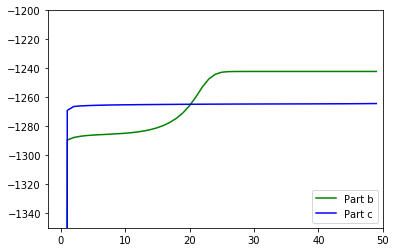

In [25]:
plt.plot(likelihood_b[:,0],likelihood_b[:,1], label='Part b', color='green')
plt.plot(likelihood_c[:,0],likelihood_c[:,1], label='Part c', color='blue')
plt.legend(loc='lower right')
plt.axis([-2, 50, -1350, -1200])

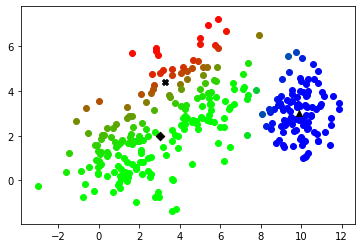

In [27]:
gamma = minmax_scale(gamma, feature_range=(0, 1), axis=0, copy=True)
for i in range(gaussian_mixture.shape[0]):
    plt.scatter(gaussian_mixture[i,0], gaussian_mixture[i,1], c=gamma[i].reshape(1,-1))
plt.scatter(mu_predicted[0,0], mu_predicted[0,1], marker='X', c='black')
plt.scatter(mu_predicted[1,0], mu_predicted[1,1], marker='D', c='black')
plt.scatter(mu_predicted[2,0], mu_predicted[2,1], marker='^', c='black')
#for some reason this cell requires multiple runs to produce output

From the scatter plot, we can also see that blue cluster was identified correctly, but read and green got mixed up. This highlights the importance of good initialization. Typically, centroids from k-means clustering are used for initial means.

---

<h4>References</h4>

[1] K. Murphy, Machine Learning: A Probabilistic Perspective. MIT Press.<br>
[2] L. Armijo, "Minimization of functions having Lipschitz continuous first partial derivatives", Pacific Journal of Mathematics, vol. 16, no. 1, pp. 1-3, 1966. Available: 10.2140/pjm.1966.16.1 [Accessed 13-Nov-2019].<br>
[3] T. H. Cormen, C. E. Leiserson, R. R. Rivest, and C. Stein, Introduction to algorithms, 2nd ed. Cambridge, Mass: MIT Press, 2001, p. 735-741.<br>
[4] "GR's Website", Data.princeton.edu, 2019. [Online]. Available: https://data.princeton.edu/wws509/datasets/#copen. [Accessed: 13-Nov-2019].<br>
[5] M. Madsen, “Statistical analysis of multiple contingency tables. Two examples,” Scandinavian Journal of Statistics, pp. 97–106, 1976.<br>
[6] N. Qian, "On the momentum term in gradient descent learning algorithms", Neural Networks, vol. 12, no. 1, pp. 145-151, 1999. Available: https://doi.org/10.1016/s0893-6080(98)00116-6.<br>
[7] Y. Nesterov, “A method for unconstrained convex minimization problem with the rate of convergence O (1/k^ 2),” in Doklady AN USSR, 1983, vol. 269, pp. 543–547.<br>
[8] O. Carrasco, "Gaussian Mixture Models Explained", Medium, 2019. [Online]. Available: https://towardsdatascience.com/gaussian-mixture-models-explained-6986aaf5a95. [Accessed: 14-Nov-2019].<br>
[9] "Gaussian Mixture Models Implementation", GitHub, 2019. [Online]. Available: https://github.com/ocontreras309/ML_Notebooks/blob/master/GMM_Implementation.ipynb. [Accessed: 14-Nov-2019].<br>

---